# Assignment Living skin detection # 


## Authors: Jan Zahn, Jonas Meier, Thomas Wiktorin ##

## Task ##

Train a classifier which is able to distinguish between living and dead materials with highest success rate
The used NN should have few most distinctive input features i.e. spectral lines

Steps:

Read all XLS and CSV data files into Python.  
Visualize them and based on your insight suggest / try some decent feature classifiers.  
Select them, train them and validate them.  
Analyse runtime and memory footprint.  
Argue why your solution is appropriate.  

EXTENSION :
please implement and compare the "Living Skin" detection using  MLP and  SVMs and radial basis functions RBFs.  
Imporant metrics are especailly confusion-matrix, precsion and recall, many more may be runtime, memory foot step  
Train time etc  


## Explanation:##

BUG NOTE: We shuffle the data to get a normalised distribution of datatypes. Sometimes the random shuffle does not shuffle the the data-matrix and class-matrix the same way order, resulting in an unusable model with 50% accuraxy. If this happens, re-run the program.

In our first program we chose to use all 121 values on the input layer, and see how accurate our model is. We reached over 96 percent accuracy consistently. Using different sizes of epochs/batch_size/validation data/training data/test data/hidden layers did not change our results in huge ways. However, I believe the size of the hidden layers is better to be small due to overfitting.   

One problem existed in the unequal representation of classes. The "living Material" has just 6 examples, while the other class is represented by 171 data sets. To reach a high accuracy, our model just classified everything as "dead material" and had instant high training and validation accuracy. Of course, this accuracy is meaningless, since we are often interested in the under represented class.  

At first, we tried to weight our examples by the means of sensitivity and specificity.  

sensitivity = true positives / positives  
specificity = true negatives / negatives  

Our model always predicts dead material and therefore has a sensitivity of 0 and specificity of 1.  
We want to achieve a model that gets close to both sensitivity and specificity beeing 1.  

Weighting did not fix our issues, so we increased the number of positive examples by duplicating them, until the numbers for each class were equal.  
This fixed our issue and we got high accuracy (>95%) and a sensitivity & specificity value close to 1.

In the second program we reduced our number of features, otherwise it is the same. 
We reduced the input layer from 121 to 12.

We looked at the second derivative and the concavity (see program 2 graphs) seemed to provide a few distinct values, important for our few features. We chose the points where the second derivative is in its extremes for both min and max, resulting in a total of 12 points.   
This resulted in a higher accuracy (>98%) and a more stable learning (see last graphs in program two)  

Runtime for an prediction of our model with 12 features takes:  
0.0001302809675962635 seconds  
And with 121:  
0.0001329888860936989 seconds  
  
340 evaluations with 121 features take:  
0.00032795901779536507 seconds  
  
340 evaluations with 12 features take:  
0.000109520259115925  

We get a slight improvement, but with our data and network size, runtime and memory does not seem to matter much.

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import csv

#-------------------------------------------------------------------------------Get Data
dataFilesOldNegatives = ["Fleisch", "Holz", "Leder", "Stoff"]
dataFilesOldPositives = ["Referenz-Haut_6-Klassen"]

dataFilesNewNegatives = ["2016material", "2016material-fake"]
dataFilesNewPositives = ["2016skin"]

def importData(fileNames):
    data = np.array([]);
    xPoints = np.array([]);
    for dataType in fileNames:
        with open("Archiv\\" + dataType + '.csv', mode='r') as csv_file:
                csv_reader = csv.reader(csv_file, delimiter=';')
                
                newList = list(csv_reader)      
                for index, row in enumerate(newList):
                   newList[index] = [value.replace(',', '.') for value in row]
                
                newData = np.asarray(newList)
                newData = np.delete(newData, (0), axis=0)
                if xPoints.size == 0:
                    xPoints = newData[:,0]
                newData = np.delete(newData,(0), axis=1)
                
                if data.size == 0:
                    data = newData.transpose()
                else:
                    data = np.append(data, newData.transpose(),axis=0)
    
        data = data.astype(np.float)
        xPoints =  xPoints.astype(np.float)    
    return xPoints, data 


#Negatives Old
xValuesOld, dataNegativesOld = importData(dataFilesOldNegatives)

#Positives Old
_, dataPositivesOld = importData(dataFilesOldPositives)

#Negatives New
xValuesNew, dataNegativesNew = importData(dataFilesNewNegatives)

#Positives New
_, dataPositivesNew = importData(dataFilesNewPositives)

#Increase positives to deal with unbalance class (maybe not needed with 2016 set)
dataPositives = np.tile(dataPositivesOld,(28,1)) 

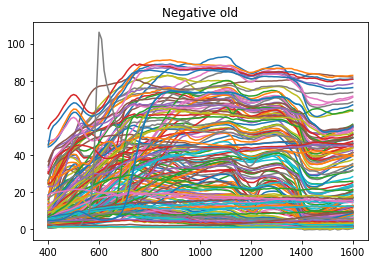

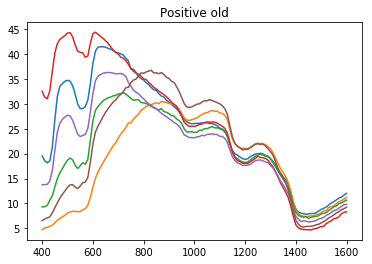

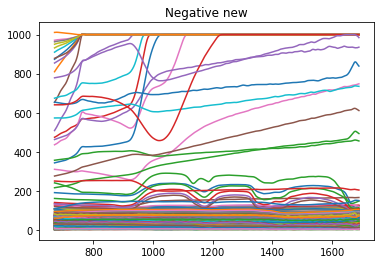

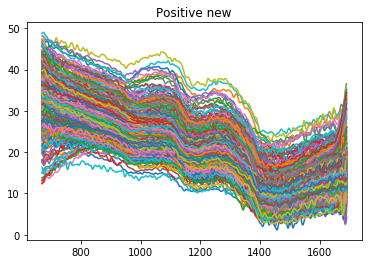

In [2]:
#--------------------------------------------------------------------------------Plott Data
def plottSpectrals(x,y,z, format=""):
    for row in y:
        plt.plot(x,row, format)
    plt.title(z)
    plt.show()
        
plottSpectrals(xValuesOld,dataNegativesOld, "Negative old")
plottSpectrals(xValuesOld,dataPositivesOld, "Positive old")
plottSpectrals(xValuesNew,dataNegativesNew, "Negative new")
plottSpectrals(xValuesNew,dataPositivesNew, "Positive new")

In [3]:
#--------------------------------------------------------------------------------Some Information on Data
print("Old xValue data: " + str(xValuesOld.shape))
print("Old negative data: " + str(dataNegativesOld.shape))
print('Old positive data: ' + str(dataPositivesOld.shape))
print("New xValue data: " + str(xValuesNew.shape))
print('New negative data: ' + str(dataNegativesNew.shape))
print('New positive data: ' + str(dataPositivesNew.shape))


Old xValue data: (121,)
Old negative data: (171, 121)
Old positive data: (6, 121)
New xValue data: (1031,)
New negative data: (367, 1031)
New positive data: (1111, 1031)


In [4]:
#---------------------------------------------------------------------------------Combine different Data
#Old wavelength 400-1600 ;                           in steps of 10
#New wavelength 670-1690 (everything after is NaN);  in steps of 1 

#Delete NaN at the end of new files
dataNegativesNew = dataNegativesNew[:,:xValuesNew.size-10]
dataPositivesNew = dataPositivesNew[:,:xValuesNew.size-10]
xValuesNew = xValuesNew[:xValuesNew.size-10]

#InterpolateOldData to match new 
tmp_positive_old = np.empty((len(dataPositivesOld),1200))
tmp_negative_old = np.empty((len(dataNegativesOld),1200))
xValuesAlteredOld = np.asarray(range(400,1600))

for i in range(len(dataPositivesOld)):
    tmp_positive_old[i,:] = np.interp(xValuesAlteredOld,xValuesOld,dataPositivesOld[i,:])

for i in range(len(dataNegativesOld)):
    tmp_negative_old[i,:] = np.interp(xValuesAlteredOld,xValuesOld,dataNegativesOld[i,:])

Average value of all measurements is 40.08500997008771


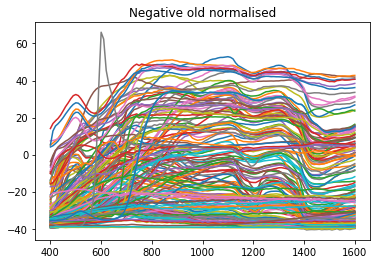

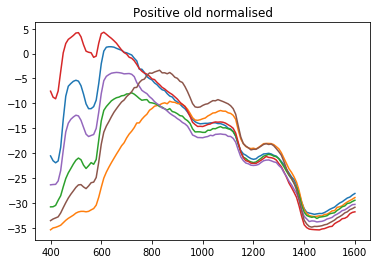

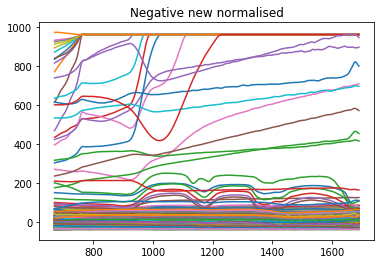

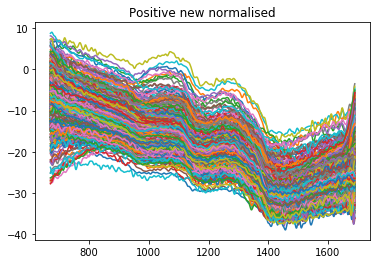

In [5]:
# Normalisation of ys over all data

# Stores average value of each measure
avg = []
for dataSet in [dataNegativesOld, dataPositivesOld, dataNegativesNew, dataPositivesNew]:
    for measure in dataSet:
        # Average for each measure
        avg.append(np.average(measure))
avg = np.average(avg)
print("Average value of all measurements is", avg)

# Use average to normalise data
for dataSet in [dataNegativesOld, dataPositivesOld, dataNegativesNew, dataPositivesNew]:
    for index, measure in enumerate(dataSet):
        # Average for each measure
        dataSet[index] = measure - avg

#--------------------------------------------------------------------------------Plott Data        
plottSpectrals(xValuesOld,dataNegativesOld, "Negative old normalised")
plottSpectrals(xValuesOld,dataPositivesOld, "Positive old normalised")
plottSpectrals(xValuesNew,dataNegativesNew, "Negative new normalised")
plottSpectrals(xValuesNew,dataPositivesNew, "Positive new normalised")

In [6]:
#---------------------------------------------------------------------------------Print new data format

xValuesOld = xValuesAlteredOld
dataNegativesOld = tmp_negative_old
dataPositivesOld = tmp_positive_old

print("After interpolation:")
print("Old negative data: " + str(dataNegativesOld.shape))
print('Old positive data: ' + str(dataPositivesOld.shape))
print('New negative data: ' + str(dataNegativesNew.shape))
print('New positive data: ' + str(dataPositivesNew.shape))

After interpolation:
Old negative data: (171, 1200)
Old positive data: (6, 1200)
New negative data: (367, 1021)
New positive data: (1111, 1021)


In [7]:
#---------------------------------------------------------------------------------Cut off old data to match new data

dataNegativesOld = dataNegativesOld[:,int(xValuesNew[0]-xValuesOld[0]):]
dataPositivesOld = dataPositivesOld[:,int(xValuesNew[0]-xValuesOld[0]):]
dataNegativesNew = dataNegativesNew[:,:int(xValuesOld[xValuesOld.size-1]-xValuesNew[0])+1]
dataPositivesNew = dataPositivesNew[:,:int(xValuesOld[xValuesOld.size-1]-xValuesNew[0])+1]

xValuesOld = np.asarray(range(670,1600))
xValuesNew = xValuesOld

In [8]:
#---------------------------------------------------------------------------------Print new data format

print("After cutting:")
print("Old negative data: " + str(dataNegativesOld.shape))
print('Old positive data: ' + str(dataPositivesOld.shape))
print('New negative data: ' + str(dataNegativesNew.shape))
print('New positive data: ' + str(dataPositivesNew.shape))

After cutting:
Old negative data: (171, 930)
Old positive data: (6, 930)
New negative data: (367, 930)
New positive data: (1111, 930)


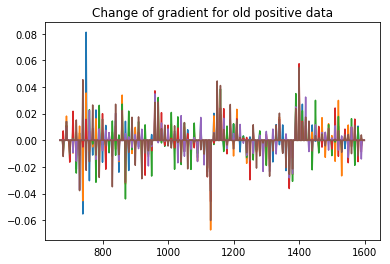

In [9]:
#---------------------------------------------------------------------------------New Features
#Extra Value for less Features (maybe)
# GradientData = 2nd derivation of input data
gradientData = np.empty([dataPositivesOld.shape[0],dataPositivesOld.shape[1]]);
i = 0;
for row in dataPositivesOld:
    gradient = np.gradient(np.gradient(row)) #where does the gradient change fastest
    plt.plot(xValuesOld,gradient)
    gradientData[i] = gradient
    i += 1
    
plt.title("Change of gradient for old positive data")
plt.show()

In [111]:
test_array = np.array([1,2,3,4,5,6,7,8,9])
print(test_array.argsort()[-3:][::-1])
print(test_array.argsort()[:3])

[8 7]
[0 1 2]


Wavelengths to use for further operations: [ 60  69  70  79  80  81  90 110 160 190 200 260 290 300 450 459 460 461
 480 490 580 640 700 710 720 729 730 731 750 850] nm.
(30,)
(300, 30)
(171, 30)
(168, 30)


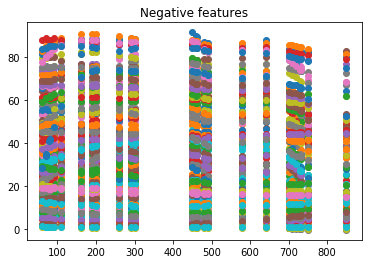

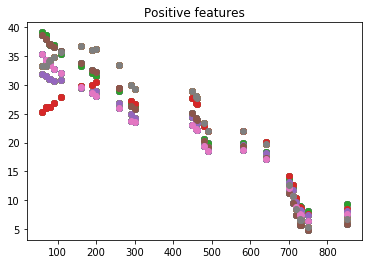

In [142]:
#--------------------------------------------------------------------------------Split Up Data
#hardcoded
# Get gradients
#maxGradients = gradientData.argmax(axis=1)
#minGradients = gradientData.argmin(axis=1)
#smallXValues = np.append(maxGradients,minGradients,axis=0)

number_of_values = 5

maxGradients = np.array([], dtype=np.int)
minGradients = np.array([], dtype=np.int)
for entry in gradientData:
    maxGradients = np.append(maxGradients, entry.argsort()[-number_of_values:][::-1])
    minGradients = np.append(minGradients, entry.argsort()[:number_of_values])

smallXValues = np.append(maxGradients,minGradients,axis=0)
    
# Remove duplicate wavelenghts
smallXValues = np.unique(smallXValues)
print("Wavelengths to use for further operations:", smallXValues, "nm.")

# Small features = only wavelengths where gradient is max or min
smallFeaturesPositiveReal = dataPositivesOld[:,smallXValues]
smallFeaturesPositive = np.tile(smallFeaturesPositiveReal,(28,1)) #Increase positives to deal with unbalance class
smallFeature = dataNegativesOld[:,smallXValues]

#[1,0] is dead, [0.1] alive
#CompleteSet Small Version
compSet = np.append(smallFeature, smallFeaturesPositive ,axis=0)
classifcSet = np.append(np.tile([1,0],(smallFeature.shape[0],1)),np.tile([0,1],(smallFeaturesPositive.shape[0],1)),axis=0)

#shuffle data together
mix = np.random.permutation(len(compSet))
compSet = compSet[mix]
classifcSet = classifcSet[mix]

#Split in training and test Data
#trainingSet = compSet[:200]
#trainingLabelSet =  classifcSet[:200]

trainingSet = compSet[:300]
trainingLabelSet =  classifcSet[:300]

#validationSet = compSet[200:300]
#validationLabelSet = classifcSet[200:300]

testSet = compSet[300:]
testLabelSet = classifcSet[300:]

print(smallXValues.shape)
print(trainingSet.shape)
print(smallFeature.shape)
print(smallFeaturesPositive.shape)

plottSpectrals(smallXValues,smallFeature, "Negative features", "o")
plottSpectrals(smallXValues,smallFeaturesPositive, "Positive features", "o")

In [161]:
#--------------------------------------------------------------------------------Build Model with tensorflow

#Simple answer; number of input layer = number of points on spectral line
spectrum = 120 

model = keras.Sequential() #Single input-output
model.add(keras.layers.Dense(20, activation=tf.nn.relu, input_shape=(trainingSet.shape[1],))) #fully-conndected = dense, with 16 units, relu: rectified linear unit
model.add(keras.layers.Dense(2, activation=tf.nn.softmax)) #Cofidence level

model.summary()


from tensorflow.keras import backend as K
def weighted_binary_crossentropy( y_true, y_pred, weight=1) :
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    logloss = -(y_true * K.log(y_pred) * weight + (1 - y_true) * K.log(1 - y_pred))
    print(type(K.mean( logloss, axis=-1)))
    print(K.mean( logloss, axis=-1))
    return K.mean( logloss, axis=-1)


#Optimizer and loss function
model.compile(optimizer=tf.train.AdamOptimizer(), #or sgd(stochastic gradient descent optimizer: keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
              loss='binary_crossentropy', #or mean_squared_error (our target is not in the continuos space), but binary seems to deal better with probabilitis
              #loss=weighted_binary_crossentropy,
              metrics=['accuracy']
              )


#Weighted class did not solve the unequal class problem
#[1,0] is dead, [0.1] alive

# Create sample weights
# Make positive samples count more
weights = []
for index, entry in enumerate(trainingSet):
    if trainingLabelSet[index][0] == 0:
        weights.append(1)
    else:
        weights.append(2)
weights = np.array(weights)

#class_weight=[3, .5]

#Train model for 50 epochs in batches of 3 samples
history = model.fit(trainingSet,
                    trainingLabelSet,
                    epochs=100,
                    batch_size=10,  #the bigger the more memory space needed
                    validation_split=0.2,
                    verbose=1,
                    sample_weight=weights,
                    #class_weight=class_weight
                    )
                    
print()
results = model.evaluate(testSet, testLabelSet)
positive = 0
negative = 0
for entry in testLabelSet:
    if entry[0] == 0:
        positive += 1
    else:
        negative += 1
        
print("Positives in testset = ", positive)
print("Negatives in testset = ", negative)

for index, metric in enumerate(model.metrics_names):
    print(metric, ": ", results[index])
    
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(testSet)
y_test = testLabelSet
#print(y_test)
#print(y_pred)
#print(y_pred.round())
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.round().argmax(axis=1))
print(cm)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_152 (Dense)            (None, 20)                620       
_________________________________________________________________
dense_153 (Dense)            (None, 2)                 42        
Total params: 662
Trainable params: 662
Non-trainable params: 0
_________________________________________________________________
Train on 240 samples, validate on 60 samples
Epoch 1/100
240/240 [==============================] - 3s 12ms/step - loss: 4.8194 - acc: 0.5750 - val_loss: 5.2182 - val_acc: 0.5500
Epoch 2/100
240/240 [==============================] - 0s 431us/step - loss: 4.0925 - acc: 0.5750 - val_loss: 4.4399 - val_acc: 0.5500
Epoch 3/100
240/240 [==============================] - 0s 416us/step - loss: 3.3322 - acc: 0.6500 - val_loss: 3.8635 - val_acc: 0.5500
Epoch 4/100
240/240 [==============================] - 0s 371us/step - loss: 2.9439 - acc: 

240/240 [==============================] - 0s 295us/step - loss: 0.3199 - acc: 0.9542 - val_loss: 0.3261 - val_acc: 0.9333
Epoch 57/100
240/240 [==============================] - 0s 314us/step - loss: 0.3026 - acc: 0.9625 - val_loss: 0.3724 - val_acc: 0.9167
Epoch 58/100
240/240 [==============================] - 0s 321us/step - loss: 0.2954 - acc: 0.9625 - val_loss: 0.4187 - val_acc: 0.9167
Epoch 59/100
240/240 [==============================] - 0s 327us/step - loss: 0.2777 - acc: 0.9250 - val_loss: 0.6210 - val_acc: 0.9000
Epoch 60/100
240/240 [==============================] - 0s 337us/step - loss: 0.3405 - acc: 0.9167 - val_loss: 0.3182 - val_acc: 0.9333
Epoch 61/100
240/240 [==============================] - 0s 243us/step - loss: 0.4121 - acc: 0.8958 - val_loss: 0.4015 - val_acc: 0.9167
Epoch 62/100
240/240 [==============================] - 0s 310us/step - loss: 0.3544 - acc: 0.9208 - val_loss: 0.3641 - val_acc: 0.9167
Epoch 63/100
240/240 [==============================] - 0s 24

In [ ]:

#--------------------------------------------------------------------------------Print Results
#Plot accuracy and loss over time
history_dict = history.history
history_dict.keys()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
# ----------------------------------------------------Some Time estimation
from timeit import default_timer as timer

start = timer()
result = model.predict(smallFeature)
end = timer()
ms = (end - start) / 1000
print("%fms"% ms)

In [21]:
#http://www.rueckstiess.net/research/snippets/show/72d2363e
from scipy import *
from scipy.linalg import norm, pinv
 
from matplotlib import pyplot as plt
 
class RBF:
     
    def __init__(self, indim, numCenters, outdim):
        self.indim = indim
        self.outdim = outdim
        self.numCenters = numCenters
        self.centers = [random.uniform(-1, 1, indim) for i in range(numCenters)]
        self.beta = 8
        self.W = random.random((self.numCenters, self.outdim))
         
    def _basisfunc(self, c, d):
        assert len(d) == self.indim
        return exp(-self.beta * norm(c-d)**2)
     
    def _calcAct(self, X):
        # calculate activations of RBFs
        G = zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        return G
     
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1 """
         
        # choose random center vectors from training set
        rnd_idx = random.permutation(X.shape[0])[:self.numCenters]
        self.centers = [X[i,:] for i in rnd_idx]
         
        print ("center", self.centers)
        # calculate activations of RBFs
        G = self._calcAct(X)
        print (G)
         
        # calculate output weights (pseudoinverse)
        self.W = dot(pinv(G), Y)
         
    def test(self, X):
        """ X: matrix of dimensions n x indim """
         
        G = self._calcAct(X)
        Y = dot(G, self.W)
        return Y
 
    
myRFB = RBF(12,3,2)
myRFB.train(trainingSet, trainingLabelSet)
myRFB.test(testSet)

# plot rbfs
plt.plot(myRFB.centers, zeros(myRFB.numCenters), 'gs')


for c in myRFB.centers:
    # RF prediction lines
    cx = c
    #cx = np.arange(c-0.7, c+0.7, 0.01)
    cy = [myRFB._basisfunc(array([cx_]), array([c])) for cx_ in cx]
    plt.plot(cx, cy, '-', color='gray', linewidth=0.2)

center [array([34.2515493 , 33.5200291 , 28.09259952, 22.29113928, 18.59687528,
        7.40837709]), array([37.90483352, 37.06731552, 32.18159067, 24.12583927, 19.20880542,
        5.71485843]), array([15.97153812, 15.85675672, 13.66904633, 16.04734979, 14.6177241 ,
        8.04433534])]


AssertionError: 

In [35]:
true = tf.convert_to_tensor([0,1], dtype=np.int32)
predict = tf.convert_to_tensor([0,1], dtype=np.int32)
def binary_crossentropy(y_true, y_pred):
    return keras.mean(keras.binary_crossentropy(y_true, y_pred), axis=-1)
print(binary_crossentropy(true, predict))

AttributeError: module 'tensorflow.keras' has no attribute 'mean'